In [1]:
import psycopg2
import pandas as pd

In [2]:
connection = psycopg2.connect( database="startml",
user="robot-startml-ro",
password="pheiph0hahj1Vaif",
host="postgres.lab.karpov.courses",
port=6432)

cursor = connection.cursor()

In [3]:
con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@""postgres.lab.karpov.courses:6432/startml"

In [4]:
df = pd.read_sql(
    """SELECT * FROM public.user_data l    
   TABLESAMPLE BERNOULLI(10)
   JOIN 
   (SELECT * from public.feed_data r 
   where action = 'view') r
   ON  l.user_id = r.user_id

 LIMIT 500000
       
 """,
    con=connection
)

df

,user_id,gender,age,country,city,exp_group,os,source,timestamp,user_id,post_id,action,target
0,117247,1,23,Russia,Nizhniy Tagil,0,Android,organic,2021-10-16 06:30:25,117247,3453,view,0
1,117247,1,23,Russia,Nizhniy Tagil,0,Android,organic,2021-10-16 06:32:47,117247,1853,view,0
2,117247,1,23,Russia,Nizhniy Tagil,0,Android,organic,2021-10-16 06:35:40,117247,1321,view,0
3,117247,1,23,Russia,Nizhniy Tagil,0,Android,organic,2021-10-16 06:36:55,117247,1157,view,0
4,117247,1,23,Russia,Nizhniy Tagil,0,Android,organic,2021-10-16 06:37:19,117247,4359,view,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,131466,0,54,Ukraine,Bila Tserkva,3,iOS,organic,2021-11-24 14:35:17,131466,6662,view,0
499996,131466,0,54,Ukraine,Bila Tserkva,3,iOS,organic,2021-11-24 14:35:35,131466,6391,view,1
499997,131466,0,54,Ukraine,Bila Tserkva,3,iOS,organic,2021-11-24 14:37:01,131466,6588,view,0
499998,131466,0,54,Ukraine,Bila Tserkva,3,iOS,organic,2021-11-24 14:39:17,131466,3477,view,0


In [5]:
df.shape

(500000, 13)

In [ ]:
cols = df.columns
cols

Index(['user_id', 'gender', 'age', 'country', 'city', 'exp_group', 'os',
       'source', 'timestamp', 'user_id', 'post_id', 'action', 'target',
       'post_id', 'text', 'topic'],
      dtype='object')

In [11]:
df.target.value_counts()

0    441356
1     58644
Name: target, dtype: int64

In [12]:
df.gender.value_counts()

1    272074
0    227926
Name: gender, dtype: int64

In [13]:
new_cols = ['timestamp','user_id', 'post_id', 'gender', 'age', 'country', 'city', 'exp_group', 'os',
       'source', 'action', 'target']

In [14]:
data = df[new_cols]

In [15]:
data.to_csv('data.csv', index=False)

In [3]:
data = pd.read_csv('data.csv',index_col=False)

# TF-IDF


Load the raw text.
Split into tokens.
Convert to lowercase.
Remove punctuation from each token.
Filter out remaining tokens that are not alphabetic.
Filter out tokens that are stop words.

In [4]:
texts = pd.read_sql(
    """SELECT * FROM post_text_df """,
    con=connection
)

texts

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [5]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

def preproccessing(text):
    tokens = word_tokenize(text)
    porter = PorterStemmer()
    #text = re.split(r'\W+', tokens) #text.split()
    text = [porter.stem(word.lower()) for word in tokens if word.isalpha()]
    text = ' '.join(text)
    return text

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')+['abov', 'becau','ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv']+['could', 'might', 'must', 'need', 'sha', 'wo', 'would']


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Зафиттим наши данные в TfidfVectorizer
tfidf = TfidfVectorizer(
                        stop_words = stop_words,
                        preprocessor = preproccessing)




In [8]:
tfidf_data = (
    tfidf
    .fit_transform(texts['text'])
    .toarray()
)

tfidf_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
tfidf_data = pd.DataFrame(
    tfidf_data,
    index=texts.post_id,
    columns=tfidf.get_feature_names_out()
)



In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=13)

PCA_dataset = pca.fit_transform(tfidf_data)

PCA_dataset = pd.DataFrame(PCA_dataset)

PCA_dataset.tail()

In [ ]:
texts_pca = pd.DataFrame(
    PCA_dataset,
    index=texts['post_id'],
    
)

In [ ]:
texts_pca=texts_pca.fillna(0)

In [36]:
texts_pca.to_csv('texts.csv')

In [18]:
texts_pca = pd.read_csv('texts.csv',index_col='post_id')

In [37]:
texts_pca.isna().sum().sum()

0

In [ ]:
all_texts = texts.merge(texts_pca, right_on = 'post_id', left_on='post_id', how='left')

In [4]:
all_texts=pd.read_csv('text_features_with_tg.csv',index_col=False)

In [5]:
all_texts.to_sql("nima_texts_features",
          con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@""postgres.lab.karpov.courses:6432/startml",
          schema = 'public',
          if_exists='replace')

In [6]:
texts_features = pd.read_sql(
    """SELECT * FROM nima_texts_features """,
    con=connection
)

texts_features

,level_0,index,post_id,text,topic,0,1,2,3,4,5,6,7,8,9,10,11,12,mean_target
0,0,0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.081230,-0.218459,0.089755,0.054286,0.017890,-0.002119,-0.028597,0.016811,0.038876,-0.043528,0.020215,0.010040,0.020806,0.129032
1,1,1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.065388,-0.129401,-0.024652,-0.102824,0.141683,-0.027064,-0.175704,-0.088795,0.029506,-0.024963,-0.001057,0.023944,0.017284,0.035714
2,2,2,3,Asian quake hits European shares\n\nShares in ...,business,0.090665,-0.091379,-0.005810,-0.062131,0.112557,0.006601,-0.075729,-0.025617,-0.050140,-0.019419,-0.000584,0.029016,0.012076,0.161290
3,3,3,4,India power shares jump on debut\n\nShares in ...,business,0.063272,-0.070623,-0.006490,-0.037587,0.037370,-0.019385,-0.034386,0.012530,-0.055766,0.017829,0.013499,0.050971,0.042781,0.181159
4,4,4,5,Lacroix label bought by US firm\n\nLuxury good...,business,0.074317,-0.094618,0.004748,-0.018693,0.025656,-0.006749,-0.049049,0.013135,-0.103267,0.025664,0.034102,0.058310,0.061785,0.093220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7018,7017,7314,Although the likeliness of someone focusing on...,movie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.148325
7019,7019,7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160305
7020,7020,7019,7316,I give this movie 2 stars purely because of it...,movie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.097222
7021,7021,7021,7318,The version I saw of this film was the Blockbu...,movie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087719


### Merging tables

In [16]:
all_data = texts_features.merge(data,right_on = 'post_id', left_on='post_id', how='left')

In [17]:
all_data = all_data.drop('action',axis=1)

### Feature engineering

In [18]:
all_data.timestamp = pd.to_datetime(all_data.timestamp, format = "%Y-%m-%d %H:%M:%S")

In [19]:
all_data=all_data.sort_values('timestamp')

In [20]:
all_data['month'] = all_data['timestamp'].dt.month

In [21]:
all_data['hour'] = all_data['timestamp'].dt.hour

In [22]:
all_data['day_week']= all_data['timestamp'].dt.dayofweek

Выделяю возрастные группы 

In [14]:
#all_data['age_group'] = pd.cut(all_data.age, bins=[0,17,25,40,80],
       #labels=["less_18", "18_to_25", "25_to_45", "more_45"])

In [23]:
def age_group(age):
    if age<18:
        age_group="less_18"
    elif age>=18 and age<25:
        age_group="18_to_25"
    elif age>=25 and age<45:
        age_group="25_to_45"
    elif age>=45 and age<=65:
        age_group= "45_to_65" 
    else:
        age_group= "others"
    return age_group

In [24]:
all_data['age_group'] = all_data['age'].apply(age_group)

In [25]:
all_data = all_data.drop('age',axis=1)

### Features encoding

In [76]:
df.exp_group = df.exp_group.astype(int)

In [18]:
df = all_data.loc[:,~all_data.columns.duplicated()].copy()

In [28]:
all_data = all_data.drop(['level_0', 'index'], axis=1)

In [31]:
all_data = all_data.set_index(['post_id'])

In [33]:
df=all_data.copy()

In [34]:
df.to_csv('all_data_new.csv')

In [35]:
df

,text,topic,0,1,2,3,4,5,6,7,...,country,city,exp_group,os,source,target,month,hour,day_week,age_group
post_id,,,,,,,,,,,,,,,,,,,,,
183,US bank boss hails genius Smith\n\nUS Federal ...,business,0.074634,-0.135467,0.010510,-0.029880,0.044500,0.017402,-0.015875,-0.011652,...,Russia,Elista,3.0,Android,ads,0.0,10.0,6.0,4.0,less_18
1429,ODriscoll saves Irish blushes\n\nTwo moments o...,sport,0.039727,-0.087012,0.040383,0.036197,-0.017494,0.000279,0.024721,0.007735,...,Russia,Elista,3.0,Android,ads,0.0,10.0,6.0,4.0,less_18
6004,Whoever filled this stupid idea of acting and ...,movie,-0.157994,0.025785,0.017522,0.016981,0.004569,-0.004600,0.008579,-0.037411,...,Russia,Elista,3.0,Android,ads,0.0,10.0,6.0,4.0,less_18
4568,This is a lovely tale of guilt-driven obsessio...,movie,-0.027047,0.017212,-0.028419,0.002478,0.009548,-0.021017,-0.005942,0.030817,...,Russia,Moscow,3.0,Android,ads,0.0,10.0,6.0,4.0,45_to_65
3847,The pro-vegan ads in L.A. blaming #covid19 on ...,covid,0.210875,0.167618,0.046451,0.046828,0.139151,0.335490,0.076854,-0.024023,...,Russia,Elista,3.0,Android,ads,0.0,10.0,6.0,4.0,less_18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3998,#Covid19 UK 5-day rolling mean for increases i...,covid,0.099097,0.069526,0.002336,-0.006190,-0.037722,-0.027271,0.008359,0.003197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,others
4089,"Unlike previous years, the #GaneshChaturthi ce...",covid,-0.110659,-0.001989,-0.081416,0.067856,0.037312,0.003460,-0.000342,-0.024335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,others
4099,@GMB @DrHilaryJones In Germany if they take a ...,covid,-0.041347,0.026555,0.012365,-0.022850,-0.016498,-0.010863,-0.018001,0.045321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,others


In [19]:
df = df.reset_index(drop=True)

In [77]:
df.dtypes

topic                  object
0                     float64
1                     float64
2                     float64
3                     float64
4                     float64
5                     float64
6                     float64
7                     float64
8                     float64
9                     float64
10                    float64
11                    float64
12                    float64
mean_target           float64
timestamp      datetime64[ns]
gender                float64
country                object
city                   object
exp_group               int64
os                     object
source                 object
target                float64
month                 float64
hour                  float64
day_week              float64
age_group              object
dtype: object

### Learning model

In [39]:
df=df.drop(['text','user_id'],axis=1)

In [78]:
cat_cols = list(df.loc[:,df.dtypes == 'object'].columns)

In [54]:
train =df.loc[df.timestamp <= df.timestamp.quantile(0.8)].drop('timestamp', axis=1)

In [42]:
train.shape

(400000, 26)

In [55]:
test = df.loc[df.timestamp > df.timestamp.quantile(0.8)].drop('timestamp', axis=1)
test.shape

(100000, 26)

In [79]:
y_train = train['target']
X_train = train.drop('target',axis=1)
y_test = test['target']
X_test=test.drop('target',axis=1)

In [80]:
cat_cols

['topic', 'country', 'city', 'os', 'source', 'age_group']

In [70]:
df

,topic,0,1,2,3,4,5,6,7,8,...,country,city,exp_group,os,source,target,month,hour,day_week,age_group
post_id,,,,,,,,,,,,,,,,,,,,,
183,business,0.074634,-0.135467,0.010510,-0.029880,0.044500,0.017402,-0.015875,-0.011652,-0.051709,...,Russia,Elista,3.0,Android,ads,0.0,10.0,6.0,4.0,less_18
1429,sport,0.039727,-0.087012,0.040383,0.036197,-0.017494,0.000279,0.024721,0.007735,-0.098196,...,Russia,Elista,3.0,Android,ads,0.0,10.0,6.0,4.0,less_18
6004,movie,-0.157994,0.025785,0.017522,0.016981,0.004569,-0.004600,0.008579,-0.037411,0.004960,...,Russia,Elista,3.0,Android,ads,0.0,10.0,6.0,4.0,less_18
4568,movie,-0.027047,0.017212,-0.028419,0.002478,0.009548,-0.021017,-0.005942,0.030817,-0.024855,...,Russia,Moscow,3.0,Android,ads,0.0,10.0,6.0,4.0,45_to_65
3847,covid,0.210875,0.167618,0.046451,0.046828,0.139151,0.335490,0.076854,-0.024023,-0.023150,...,Russia,Elista,3.0,Android,ads,0.0,10.0,6.0,4.0,less_18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,covid,0.056935,-0.132314,0.007822,-0.028171,0.059067,-0.028936,0.020984,-0.010237,-0.186457,...,Russia,Moscow,0.0,Android,ads,0.0,12.0,23.0,2.0,25_to_45
6892,movie,-0.028749,0.028408,-0.002585,-0.026755,-0.045245,-0.008968,-0.002319,-0.023120,0.018095,...,Russia,Chelyabinsk,3.0,Android,organic,0.0,12.0,23.0,2.0,18_to_25
973,politics,-0.038826,-0.050533,-0.169133,0.053394,-0.015150,0.049015,-0.122991,0.328688,0.072723,...,Russia,Moscow,0.0,Android,ads,1.0,12.0,23.0,2.0,25_to_45


In [53]:
df=df.dropna()

In [89]:
df.columns

Index(['topic', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', 'mean_target', 'timestamp', 'gender', 'country', 'city',
       'exp_group', 'os', 'source', 'target', 'month', 'hour', 'day_week',
       'age_group'],
      dtype='object')

In [71]:
df.isna().sum().sum()

0

In [87]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=200,
                              learning_rate=0.3,
                              depth=3)

catboost.fit(X_train, y_train, cat_features=cat_cols)



0:	learn: 0.5010294	total: 232ms	remaining: 46.1s
1:	learn: 0.4187046	total: 489ms	remaining: 48.4s
2:	learn: 0.3803052	total: 757ms	remaining: 49.7s
3:	learn: 0.3626511	total: 1.01s	remaining: 49.4s
4:	learn: 0.3542024	total: 1.25s	remaining: 48.8s
5:	learn: 0.3475066	total: 1.52s	remaining: 49.2s
6:	learn: 0.3438704	total: 1.74s	remaining: 47.9s
7:	learn: 0.3422156	total: 1.94s	remaining: 46.5s
8:	learn: 0.3412652	total: 2.08s	remaining: 44.2s
9:	learn: 0.3406879	total: 2.3s	remaining: 43.7s
10:	learn: 0.3388716	total: 2.57s	remaining: 44.1s
11:	learn: 0.3386040	total: 2.76s	remaining: 43.2s
12:	learn: 0.3383336	total: 2.97s	remaining: 42.7s
13:	learn: 0.3380928	total: 3.16s	remaining: 42s
14:	learn: 0.3377081	total: 3.35s	remaining: 41.3s
15:	learn: 0.3369097	total: 3.63s	remaining: 41.8s
16:	learn: 0.3367300	total: 3.85s	remaining: 41.5s
17:	learn: 0.3366040	total: 4.07s	remaining: 41.2s
18:	learn: 0.3365336	total: 4.27s	remaining: 40.7s
19:	learn: 0.3364705	total: 4.49s	remaining:

In [82]:
from sklearn.metrics import roc_auc_score

In [88]:
print(f"Качество на трейне: {roc_auc_score(y_train,catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6976793738118994
Качество на тесте: 0.6518195505739577


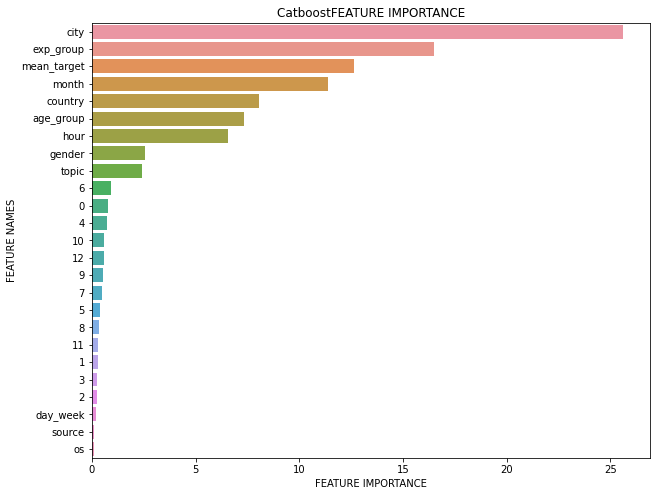

In [84]:
### Посмотрим на feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')

In [ ]:
catboost.fit(df.drop(['timestamp','target'],axis=1), df.target, cat_cols)

0:	learn: 0.5065452	total: 327ms	remaining: 1m 5s
1:	learn: 0.4256455	total: 628ms	remaining: 1m 2s
2:	learn: 0.3888447	total: 910ms	remaining: 59.8s
3:	learn: 0.3707071	total: 1.22s	remaining: 59.9s
4:	learn: 0.3628366	total: 1.43s	remaining: 55.7s
5:	learn: 0.3589417	total: 1.67s	remaining: 54.1s
6:	learn: 0.3538504	total: 1.87s	remaining: 51.5s
7:	learn: 0.3514164	total: 2.12s	remaining: 51s
8:	learn: 0.3501616	total: 2.31s	remaining: 49.1s
9:	learn: 0.3495080	total: 2.55s	remaining: 48.4s
10:	learn: 0.3489053	total: 2.76s	remaining: 47.5s
11:	learn: 0.3486791	total: 3.05s	remaining: 47.8s
12:	learn: 0.3484124	total: 3.31s	remaining: 47.6s
13:	learn: 0.3481726	total: 3.54s	remaining: 47s
14:	learn: 0.3479937	total: 3.78s	remaining: 46.7s
15:	learn: 0.3478830	total: 4.09s	remaining: 47s
16:	learn: 0.3476569	total: 4.36s	remaining: 46.9s
17:	learn: 0.3475428	total: 4.64s	remaining: 46.9s
18:	learn: 0.3474109	total: 4.96s	remaining: 47.3s
19:	learn: 0.3471908	total: 5.2s	remaining: 46.

In [92]:
print(f"Качество на трейне: {roc_auc_score(df.target, catboost.predict_proba(df.drop(['timestamp','target'],axis=1))[:, 1]) }")


Качество на трейне: 0.6916020595395489


In [93]:
catboost.save_model('sim_catboost_model',
                           format="cbm")

from_file = CatBoostClassifier()  # здесь не указываем параметры, которые были при обучении, в дампе модели все есть

from_file.load_model("sim_catboost_model")

from_file.predict(X_train)

array([0., 0., 0., ..., 0., 0., 0.])

In [94]:
df.columns

Index(['topic', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', 'mean_target', 'timestamp', 'gender', 'country', 'city',
       'exp_group', 'os', 'source', 'target', 'month', 'hour', 'day_week',
       'age_group'],
      dtype='object')

In [6]:
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [60]:
numeric_features = ['gender', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', 'month', 'hour', 'day_week']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['country', 'city', 'exp_group', 'os', 'source', 'topic', 'age_group'] #object_cols
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

cbst_sca = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  CatBoostClassifier(iterations=200,
                              learning_rate=0.4,
                              depth=4))])




In [61]:
cbst_sca.fit(X_train, y_train)

0:	learn: 0.4620514	total: 63ms	remaining: 12.5s
1:	learn: 0.3907386	total: 116ms	remaining: 11.4s
2:	learn: 0.3667498	total: 167ms	remaining: 11s
3:	learn: 0.3568860	total: 216ms	remaining: 10.6s
4:	learn: 0.3530897	total: 269ms	remaining: 10.5s
5:	learn: 0.3516557	total: 335ms	remaining: 10.8s
6:	learn: 0.3505446	total: 395ms	remaining: 10.9s
7:	learn: 0.3499485	total: 464ms	remaining: 11.1s
8:	learn: 0.3496080	total: 516ms	remaining: 11s
9:	learn: 0.3493128	total: 583ms	remaining: 11.1s
10:	learn: 0.3489955	total: 667ms	remaining: 11.5s
11:	learn: 0.3483072	total: 749ms	remaining: 11.7s
12:	learn: 0.3480838	total: 807ms	remaining: 11.6s
13:	learn: 0.3478828	total: 872ms	remaining: 11.6s
14:	learn: 0.3477732	total: 938ms	remaining: 11.6s
15:	learn: 0.3476890	total: 1.02s	remaining: 11.7s
16:	learn: 0.3470241	total: 1.09s	remaining: 11.7s
17:	learn: 0.3469346	total: 1.15s	remaining: 11.6s
18:	learn: 0.3468242	total: 1.21s	remaining: 11.6s
19:	learn: 0.3466721	total: 1.28s	remaining: 1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gender', '0', '1', '2', '3',
                                                   '4', '5', '6', '7', '8', '9',
                                                   '10', '11', '12', 'month',
                                                   'hour', 'day_week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
              

In [63]:
print(f"Качество на трейне: {roc_auc_score(y_train, cbst_sca.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, cbst_sca.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6930551554945852
Качество на тесте: 0.6376819182288119


Подается user_id,datetime,limit

Находим юзера в табле с юзерами
Формируем датасет:
прибавляем к датасету с постами (7023строки) константные колонки с пользователем (возр группа, пол, страна...

In [1]:
import datetime

In [2]:
id = 148062
time =  datetime.datetime(2021, 10,1,6,7,13)   

In [7]:
user = pd.read_sql(
    """SELECT * FROM public.user_data 
    where user_id = 148062
       
 """,
    con=connection
)

user

,user_id,gender,age,country,city,exp_group,os,source
0,148062,0,35,Russia,Moscow,0,Android,organic


In [9]:
def age_group(age):
    if age<18:
        age_group="less_18"
    elif age>=18 and age<25:
        age_group="18_to_25"
    elif age>=25 and age<45:
        age_group="25_to_45"
    else:
        age_group= "more_45" 
    return age_group

In [10]:
user['age_group'] = user['age'].apply(age_group)

In [11]:
user.drop('age',axis=1,inplace=True)

In [12]:
user['month']=time.month
user['hour']=time.hour
user['day_week']=time.weekday()

In [13]:
list(user.columns)

['user_id',
 'gender',
 'country',
 'city',
 'exp_group',
 'os',
 'source',
 'age_group',
 'month',
 'hour',
 'day_week']

In [8]:
texts_features = pd.read_sql(
    """SELECT * FROM nima_texts_features """,
    con=connection
)

texts_features

,level_0,index,post_id,text,topic,0,1,2,3,4,5,6,7,8,9,10,11,12,mean_target
0,0,0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.081230,-0.218459,0.089755,0.054286,0.017890,-0.002119,-0.028597,0.016811,0.038876,-0.043528,0.020215,0.010040,0.020806,0.129032
1,1,1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.065388,-0.129401,-0.024652,-0.102824,0.141683,-0.027064,-0.175704,-0.088795,0.029506,-0.024963,-0.001057,0.023944,0.017284,0.035714
2,2,2,3,Asian quake hits European shares\n\nShares in ...,business,0.090665,-0.091379,-0.005810,-0.062131,0.112557,0.006601,-0.075729,-0.025617,-0.050140,-0.019419,-0.000584,0.029016,0.012076,0.161290
3,3,3,4,India power shares jump on debut\n\nShares in ...,business,0.063272,-0.070623,-0.006490,-0.037587,0.037370,-0.019385,-0.034386,0.012530,-0.055766,0.017829,0.013499,0.050971,0.042781,0.181159
4,4,4,5,Lacroix label bought by US firm\n\nLuxury good...,business,0.074317,-0.094618,0.004748,-0.018693,0.025656,-0.006749,-0.049049,0.013135,-0.103267,0.025664,0.034102,0.058310,0.061785,0.093220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7018,7017,7314,Although the likeliness of someone focusing on...,movie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.148325
7019,7019,7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160305
7020,7020,7019,7316,I give this movie 2 stars purely because of it...,movie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.097222
7021,7021,7021,7318,The version I saw of this film was the Blockbu...,movie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087719


In [10]:
list(user.columns)

['user_id', 'gender', 'age', 'country', 'city', 'exp_group', 'os', 'source']

In [11]:
add_user_features = dict(zip(user.columns, user.values[0]))
add_user_features 

{'user_id': 148062,
 'gender': 0,
 'age': 35,
 'country': 'Russia',
 'city': 'Moscow',
 'exp_group': 0,
 'os': 'Android',
 'source': 'organic'}

In [13]:
#texts_features[list(user.columns)] = user.values[0] #{user.col : user.values[0] for col in user}

In [17]:
texts_user_features = texts_features.assign(**add_user_features)

In [18]:
texts_user_features

,index,post_id,text,topic,0,1,2,3,4,5,...,gender,country,city,exp_group,os,source,age_group,month,hour,day_week
0,0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.081230,-0.218459,0.089755,0.054286,0.017890,-0.002119,...,0,Russia,Moscow,0,Android,organic,25_to_45,10,6,4
1,1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.065388,-0.129401,-0.024652,-0.102824,0.141683,-0.027064,...,0,Russia,Moscow,0,Android,organic,25_to_45,10,6,4
2,2,3,Asian quake hits European shares\n\nShares in ...,business,0.090665,-0.091379,-0.005810,-0.062131,0.112557,0.006601,...,0,Russia,Moscow,0,Android,organic,25_to_45,10,6,4
3,3,4,India power shares jump on debut\n\nShares in ...,business,0.063272,-0.070623,-0.006490,-0.037587,0.037370,-0.019385,...,0,Russia,Moscow,0,Android,organic,25_to_45,10,6,4
4,4,5,Lacroix label bought by US firm\n\nLuxury good...,business,0.074317,-0.094618,0.004748,-0.018693,0.025656,-0.006749,...,0,Russia,Moscow,0,Android,organic,25_to_45,10,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7017,7314,Although the likeliness of someone focusing on...,movie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,Russia,Moscow,0,Android,organic,25_to_45,10,6,4
7019,7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,Russia,Moscow,0,Android,organic,25_to_45,10,6,4
7020,7019,7316,I give this movie 2 stars purely because of it...,movie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,Russia,Moscow,0,Android,organic,25_to_45,10,6,4
7021,7021,7318,The version I saw of this film was the Blockbu...,movie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,Russia,Moscow,0,Android,organic,25_to_45,10,6,4


In [19]:
posts = texts_user_features[['post_id','text','topic']]

In [20]:
texts_user_features = texts_user_features.drop(['user_id','text','index'],axis=1)

In [21]:
texts_user_features = texts_user_features.set_index('post_id')

In [22]:
texts_user_features.columns

Index(['topic', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', 'gender', 'country', 'city', 'exp_group', 'os', 'source',
       'age_group', 'month', 'hour', 'day_week'],
      dtype='object')

In [24]:
texts_user_features = texts_user_features[['gender', 'country', 'city', 'exp_group', 'os', 'source', 'topic', '0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'month',
       'hour', 'day_week', 'age_group']]

In [36]:
post_idx = texts_user_features.sort_values('preds',ascending=False).head(5).index

In [39]:
post_idx 

Int64Index([2321, 2019, 2876, 5279, 6024], dtype='int64', name='post_id')

In [38]:
posts.set_index('post_id').loc[post_idx]

,text,topic
post_id,,
2321,The Force is strong in Battlefront\n\nThe warm...,tech
2019,Game makers get Xbox 2 sneak peek\n\nMicrosoft...,tech
2876,"#UK #insurers paid the equivalent of £980,000 ...",covid
5279,"With the exception of FAMILY, this new season ...",movie
6024,Now I dont hate cheap movies. I just dont see ...,movie


In [5]:
ff = pd.read_sql(
    """SELECT * FROM public.feed_data 
      TABLESAMPLE BERNOULLI(10)
      WHERE action = 'view'
      LIMIT 1000000
 """,
    con=connection
)

ff

,timestamp,user_id,post_id,action,target
0,2021-12-23 18:54:41,147411,64,view,0
1,2021-12-23 19:14:58,147411,1522,view,0
2,2021-12-23 19:34:35,147411,6650,view,0
3,2021-10-17 13:42:27,56903,1110,view,0
4,2021-10-17 14:01:59,56903,1987,view,0
...,...,...,...,...,...
999995,2021-11-09 16:04:08,38986,5551,view,0
999996,2021-11-10 15:31:54,38986,1635,view,0
999997,2021-11-10 15:46:20,38986,3088,view,0
999998,2021-11-12 19:34:07,38986,1645,view,0


### Lets find the most active users 
user['pos'], post['pop']

In [6]:
user_pos = ff.groupby('user_id').agg({'target':'mean'})

In [ ]:
user_pos.to_csv('user_pos.csv', index = False)

In [9]:
post_pop = ff.groupby('post_id').agg({'target':'mean'}).rename({'target':'post_pop'})

In [11]:
post_pop

,target
post_id,
1,0.129032
2,0.035714
3,0.161290
4,0.181159
5,0.093220
...,...
7315,0.160305
7316,0.097222
7317,0.127273


In [13]:
all_text_features = texts_features.merge(post_pop, left_on = 'post_id', right_on = 'post_id', how='left')

In [17]:
all_text_features = all_text_features.rename(columns ={'target':'mean_target'})

In [19]:
all_text_features.to_csv('text_features_with_tg.csv', index=False)

In [20]:
all_users = pd.read_sql(
    """SELECT * FROM public.user_data 
       
 """,
    con=connection
)

all_users

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [23]:
all_users.merge(user_pos, left_on = 'user_id', right_on = 'user_id', how='left')

,user_id,gender,age,country,city,exp_group,os,source,target
0,200,1,34,Russia,Degtyarsk,3,Android,ads,NaN
1,201,0,37,Russia,Abakan,0,Android,ads,NaN
2,202,1,17,Russia,Smolensk,4,Android,ads,NaN
3,203,0,18,Russia,Moscow,1,iOS,ads,NaN
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,NaN
...,...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic,NaN
163201,168549,0,18,Russia,Tula,2,Android,organic,NaN
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic,NaN
163203,168551,0,38,Russia,Moscow,3,iOS,organic,NaN


In [22]:
all_users

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [126]:

def batch_load_sql(query: str):
    engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )
    conn = engine.connect().execution_options(
        stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=200000):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)



In [124]:
def get_model_path(path: str) -> str:
    # Корректный путь для загрузки модели

    if os.environ.get("IS_LMS") == "1":
        MODEL_PATH = 'sim_catboost_model'
    else:
        MODEL_PATH = path
    return MODEL_PATH


def load_features():
    # Уникальные записи post_id, user_id
    # Где был совершен лайк


    liked_posts = pd.read_sql(
         """SELECT distinct post_id, user_id
           FROM public.feed_data

            where action='like'""",

         con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
             "postgres.lab.karpov.courses:6432/startml"
     )

    # Фичи по постам на основе tf-idf

    posts_features = pd.read_sql(
        """SELECT * FROM public.nima_texts_features""",

        con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
            "postgres.lab.karpov.courses:6432/startml"
    )

    # Фичи по юзерам

    user_features = pd.read_sql(
        """SELECT * FROM public.user_data""",

        con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
            "postgres.lab.karpov.courses:6432/startml"
    )
    return [liked_posts, posts_features, user_features]


def age_group(age):
    if age < 18:
        age_group = "less_18"
    elif age >= 18 and age < 25:
        age_group = "18_to_25"
    elif age >= 25 and age < 45:
        age_group = "25_to_45"
    elif age >= 45 and age <= 65:
        age_group = "45_to_65"
    else:
        age_group = "others"
    return age_group


def load_models():
    ### Загрузка Catboost

    model_path = get_model_path("sim_catboost_model")
    loaded_model = CatBoostClassifier()
    loaded_model.load_model(model_path)
    return loaded_model











In [138]:
model = load_models()

features = load_features()

In [139]:
import datetime
from datetime import time

In [140]:
id = 148062
time =  datetime.datetime(2021, 10,1,6,7,13)
limit =5

In [147]:
features[2]['age_group'] = features[2].age.apply(age_group) 


In [148]:
user_features = features[2].loc[features[2].user_id == id]
user_features

,user_id,gender,age,country,city,exp_group,os,source,age_group
142727,148062,0,35,Russia,Moscow,0,Android,organic,25_to_45


In [149]:
user_features = user_features.drop(['user_id', 'age'], axis=1)

In [169]:
   # Загрузим фичи по постам

posts = features[1][['post_id','text','topic']].set_index('post_id')

posts_features = features[1].drop(['index', 'text'], axis=1)

add_user_features = dict(zip(user_features.columns, user_features.values[0]))
 

In [151]:
user_posts_features = posts_features.assign(**add_user_features)
user_posts_features = user_posts_features.set_index('post_id')

    # adding info about date of reccomendation

user_posts_features['hour'] = time.hour
user_posts_features['month'] = time.month
user_posts_features['day_week'] = time.weekday()

user_posts_features = user_posts_features[['topic', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
                                               '12', 'mean_target', 'gender', 'country', 'city',
                                               'exp_group', 'os', 'source', 'month', 'hour', 'day_week',
                                               'age_group']]


predicts = model.predict_proba(user_posts_features)[:, 1]
user_posts_features["predicts"] = predicts


In [152]:
liked_posts = features[0][features[0].user_id == id].post_id.values
filtered_ = user_posts_features[~user_posts_features.index.isin(liked_posts)]

    # Рекомендуем топ-5 по вероятности постов
recommended_posts = filtered_.sort_values('predicts')[-limit:].index




In [154]:
recommended_posts

Int64Index([3428, 608, 618, 467, 577], dtype='int64', name='post_id')

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7314,Although the likeliness of someone focusing on...,movie
7019,7315,"OK, I would not normally watch a Farrelly brot...",movie
7020,7316,I give this movie 2 stars purely because of it...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [176]:
posts = posts.loc[recommended_posts].reset_index()

In [177]:
posts

,post_id,text,topic
0,3428,New foreign students barred from entering US i...,covid
1,608,Abba reunite for musical premiere\n\nThe origi...,entertainment
2,618,Elton plays Paris charity concert\n\nSir Elton...,entertainment
3,467,French wine gets 70m euro top-up\n\nThe French...,business
4,577,Bollywood draws global stars\n\nBritish actres...,entertainment


In [178]:
[{"id": i[0], "text": i[1], "topic": i[2]} for i in posts.itertuples(index=False)]

[{'id': 3428,
  'text': 'New foreign students barred from entering US if all classes online: Report\nhttps://t.co/M7HqeWBTCQ\n#US,… https://t.co/CHRQXBoXph',
  'topic': 'covid'},
 {'id': 608,
  'text': 'Abba reunite for musical premiere\n\nThe original stars of Swedish pop quartet Abba have reunited for the home premiere of hit musical Mamma Mia! which is based on the bands songs.\n\nIt is the first time in almost 20 years that the four, Bjorn Ulvaeus, Benny Andersson, Agnetha Faltskog and Anni-Frid Lyngstad, have met publicly. Faltskog has been a virtual recluse since the band split up in 1982. The musical, which has become a global phenomenon, will be performed in Swedish for the first time. Fans camped outside Stockholms Cirkus theatre in the snow for a glimpse of the stars. The premiere marks Abbas first public reunion since the legendary bands acrimonious break-up in the early 1980s. It was thought that Faltskog would appear in London for the musicals fifth anniversary celebration

### Saving model

In [4]:
from catboost import CatBoostClassifier
loaded_model = CatBoostClassifier()
loaded_model.load_model("sim_catboost_model_1")